In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score,\
precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

**Загрузим тестовый датасет. Он состоит из 3 признаков и таргета.**

In [2]:
df = pd.read_csv('Skin_NonSkin.txt',
                 sep='\t',
                 header=None,
                 names=['attr_1','attr_2', 'attr_3', 'target'])
df['target'].replace({2: 0}, inplace=True)

display(df.head(2))

attr_1  attr_2  attr_3  target
0      74      85     123       1
1      73      84     122       1

In [3]:
print(f'Соотношение значений целевой переменной:\n{df["target"].value_counts()}')

Соотношение значений целевой переменной:
0    194198
1     50859
Name: target, dtype: int64


In [4]:
X = df.loc[:, ~df.columns.isin(['target'])]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
metrics = {
    'method': [],
    'f1_score': [],
    'roc': [],
    'recall':[],
    'precision':[]
}

**Обучим XGBClassifier() с параметрами по умолчанию на изначальном датасете и посмотрим на метрики:**

In [6]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0))
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0))
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))

In [7]:
model = XGBClassifier()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

Classification results:
f1: 99.87%
roc: 99.95%
recall: 99.96%
precision: 99.78%


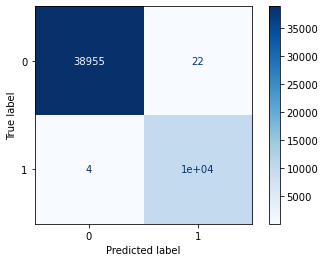

In [8]:
evaluate_results(y_test, y_predict)

plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('original')
metrics['f1_score'].append(f1_score(y_test, y_predict))
metrics['roc'].append(roc_auc_score(y_test, y_predict))
metrics['recall'].append(recall_score(y_test, y_predict, average='binary'))
metrics['precision'].append(precision_score(y_test, y_predict, average='binary'))

***

## Positive-Unlabeled (PU) Learning

Но что делать, если в нашем датасете есть разметка только для positive?

В таком случае решается задача как задача **Positive-Unlabeled (PU) Learning**

**Positive-Unlabeled (PU) Learning** можно перевести как «обучение на основе положительных и неразмеченных данных».

По сути, **PU Learning** — это аналог бинарной классификации для случаев, когда имеются размеченные данные только одного из классов, но доступна неразмеченная смесь данных обоих классов.

В целом мы даже не знаем, сколько данных соответствует положительному классу, а сколько — отрицательному. На основе такого набора данных мы хотим построить бинарный классификатор: такой же, как и при наличии размеченных данных для классов 0 и 1.

Пример: есть сегмент пользователей, которые пользуются зарплатным проектом. Мы хотим находить "похожих".

Возможное (очевидное) решение - построить бинарный классификатор, который будет отличать тех, кому нужен зарплатный проект от тех, кому он не нужен.

Проблема - нет понимания что считать "негативами"

В картинках это выглядит так:

![ab_split](example2.png "example1")

***

![ab_split](example3.png "example2")

### Более формальное описание задачи

1. Оценивается вероятность того, что пользователь совершит некоторое целевое действие (например, приобретение продукта и т. д.)
2. У нас есть только те, кто совершил это действие - это positives (P). При этом нет определения того, что такое negative (N). Все, кроме P - Unlabeled (U)
3. Нам нужно как-то собрать выборку и обучить модель, которая будет отличать P от N 

Получаем такие обозначения: P, U, N (сначала у нас есть только первые 2).

***

## Random Negative Sampling

1. **Оставляем только 25% positives размеченными**

In [9]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 25% positives размеченными
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2,'unlabeled_target'] = 1
print('unlabeled_target:\n', mod_df['unlabeled_target'].value_counts(), '\n')

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['unlabeled_target']==-1][:len(mod_df[mod_df['unlabeled_target']==1])]
sample_test = mod_df[mod_df['unlabeled_target']==-1][len(mod_df[mod_df['unlabeled_target']==1]):]
pos_sample = mod_df[mod_df['unlabeled_target']==1]
print(f'neg_sample: {neg_sample.shape}, pos_sample: {pos_sample.shape}')
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

Используем 12715/50859 как позитивные примеры, а остальное - неразмеченные

unlabeled_target:
 -1    232342
 1     12715
Name: unlabeled_target, dtype: int64 

new_target:
 0    232342
1     12715
Name: new_target, dtype: int64 

neg_sample: (12715, 6), pos_sample: (12715, 6)


In [10]:
print('sample_train')
display(sample_train.shape)
display(sample_train.head(2))

sample_train


(25430, 6)

attr_1  attr_2  attr_3  target  unlabeled_target  new_target
138097     196     195     157       0                -1           0
15557      137     174     248       1                 1           1

**Обучим XGBClassifier() с параметрами по умолчанию на датасете с 25% размеченных данных, собранном с RNS**

y_train:
 0    12715
1    12715
Name: new_target, dtype: int64
y_test:
 0    183549
1     36078
Name: target, dtype: int64

25% labels with RNS в 1 заход (сейчас это получается простой undersampling):
Classification results:
f1: 100.00%
roc: 100.00%
recall: 100.00%
precision: 100.00%


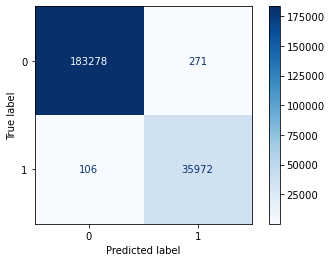

In [11]:
model = XGBClassifier()

y_train = sample_train['new_target']
y_test = sample_test['target']

print(f'y_train:\n {y_train.value_counts()}\ny_test:\n {y_test.value_counts()}\n')

model.fit(sample_train.loc[:, ~sample_train.columns.isin(['target', 'unlabeled_target', 'new_target'])].values, 
          sample_train['new_target'].values)
y_predict = model.predict(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target'])].values)

print('25% labels with RNS в 1 заход (сейчас это получается простой undersampling):')
evaluate_results(sample_test['target'].values, y_test)

plot_confusion_matrix(model,
                      sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target'])].values,
                      y_test,
                      cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('25% RNS 1 cycle')
metrics['f1_score'].append(f1_score(sample_test['target'].values, y_predict))
metrics['roc'].append(roc_auc_score(sample_test['target'].values, y_predict))
metrics['recall'].append(recall_score(sample_test['target'].values, y_predict, average='binary'))
metrics['precision'].append(precision_score(sample_test['target'].values, y_predict, average='binary'))

**Идём на второй заход с отобранными strong negative значениями**

In [12]:
y_predict_proba = model.predict_proba(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target'])].values)
sample_test['predict_proba'] = y_predict_proba[:, 0]

# рассчитаем такой порог, чтобы кол-во strong negatives было больше или равно positives
qunatile_threshold = 1
threshold = sample_test['predict_proba'].quantile(qunatile_threshold)
while (sample_test['predict_proba'].loc[sample_test['predict_proba'] > threshold].shape[0]) < pos_sample.shape[0]:
    qunatile_threshold -= 0.0001
    threshold = sample_test['predict_proba'].quantile(qunatile_threshold)
print(f'Пороговое значение вероятности: {threshold}')

mod_df = pd.concat([mod_df, sample_test['predict_proba'].loc[sample_test['predict_proba'] > threshold]],
                                axis=1)
mod_df.fillna(0, inplace=True)

Пороговое значение вероятности: 0.999998927116394


In [13]:
# получаем индексы strong negative samples
strong_neg_ind = np.where(mod_df['predict_proba'].values > 0)[0]
mod_df.drop(columns=['predict_proba'], inplace=True)
# перемешиваем
np.random.shuffle(strong_neg_ind)
strong_neg_sample = strong_neg_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2, 'unlabeled_target'] = 1
mod_df.loc[strong_neg_sample, 'unlabeled_target'] = 0

mod_df['new_target'] = 0
mod_df.loc[pos_sample_2,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['unlabeled_target']==0][:len(mod_df[mod_df['unlabeled_target']==1])]
sample_test = mod_df[mod_df['unlabeled_target']==-1][len(mod_df[mod_df['unlabeled_target']==1]):]
pos_sample = mod_df[mod_df['unlabeled_target']==1]
print(f'strong_neg_sample: {neg_sample.shape}, pos_sample: {pos_sample.shape}')
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

new_target:
 0    232342
1     12715
Name: new_target, dtype: int64 

strong_neg_sample: (12715, 6), pos_sample: (12715, 6)


In [14]:
print('sample_train')
display(sample_train.shape)
display(sample_train.head(2))

sample_train


(25430, 6)

attr_1  attr_2  attr_3  target  unlabeled_target  new_target
237103     164     164     116       0                 0           0
110075     173     172     122       0                 0           0

**Обучим XGBClassifier() с параметрами по умолчанию на датасете с 25% размеченных данных, собранном с RNS и отобранными strong negatives**

y_train:
 0    12715
1    12715
Name: new_target, dtype: int64
y_test:
 0    170998
1     35914
Name: target, dtype: int64

25% labels with RNS в 2 захода:
Classification results:
f1: 46.11%
roc: 75.45%
recall: 100.00%
precision: 29.96%


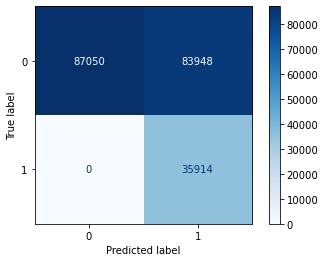

In [15]:
model = XGBClassifier()

y_train = sample_train['new_target']
y_test = sample_test['target']

print(f'y_train:\n {y_train.value_counts()}\ny_test:\n {y_test.value_counts()}\n')

model.fit(sample_train.loc[:, ~sample_train.columns.isin(['target',
                                                          'unlabeled_target',
                                                          'new_target',
                                                          'predict_proba'])].values, 
          sample_train['new_target'].values)
y_predict = model.predict(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target',
                                                                        'predict_proba'])].values)
print('25% labels with RNS в 2 захода:')
evaluate_results(sample_test['target'].values, y_predict)

plot_confusion_matrix(model,
                      sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                    'unlabeled_target',
                                                                    'new_target',
                                                                    'predict_proba'])].values,
                      y_test,
                      cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('25% RNS 2 cycles')
metrics['f1_score'].append(f1_score(sample_test['target'].values, y_predict))
metrics['roc'].append(roc_auc_score(sample_test['target'].values, y_predict))
metrics['recall'].append(recall_score(sample_test['target'].values, y_predict, average='binary'))
metrics['precision'].append(precision_score(sample_test['target'].values, y_predict, average='binary'))

**Обучим XGBClassifier() с параметрами по умолчанию на полном датасете с 25% размеченных данных**

In [16]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target', 'unlabeled_target', 'new_target'])]
y = mod_df['new_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

25% labels with simple XGBoost:
Classification results:
f1: 0.15%
roc: 50.02%
recall: 0.08%
precision: 12.50%


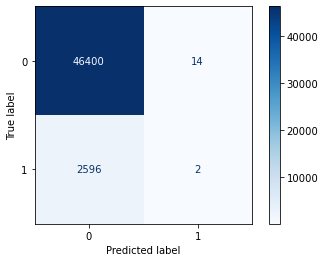

In [17]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target', 'unlabeled_target', 'new_target'])]
y = mod_df['new_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('25% labels with simple XGBoost:')
evaluate_results(y_test, y_predict)

plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('25% labels simple xgboost')
metrics['f1_score'].append(f1_score(y_test, y_predict))
metrics['roc'].append(roc_auc_score(y_test, y_predict))
metrics['recall'].append(recall_score(y_test, y_predict, average='binary'))
metrics['precision'].append(precision_score(y_test, y_predict, average='binary'))

**Обучим XGBClassifier() с параметрами по умолчанию на датасете с 25% размеченных данных и использованием RandomUnderSampler**

0    12715
1    12715
Name: new_target, dtype: int64

25% labels with RandomUnderSampler:
Classification results:
f1: 39.92%
roc: 91.69%
recall: 99.82%
precision: 24.95%


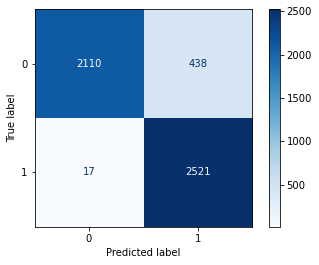

In [18]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target', 'unlabeled_target', 'new_target'])]
y = mod_df['new_target']

RUS = RandomUnderSampler(sampling_strategy='majority')

X_res, y_res = RUS.fit_resample(X, y)

display(y_res.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)
y_predict = model.predict(X)

print('25% labels with RandomUnderSampler:')
evaluate_results(y, y_predict)

plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('25% labels RandomUnderSampler')
metrics['f1_score'].append(f1_score(y, y_predict))
metrics['roc'].append(roc_auc_score(y, y_predict))
metrics['recall'].append(recall_score(y, y_predict, average='binary'))
metrics['precision'].append(precision_score(y, y_predict, average='binary'))

***

2. **Оставлем только 0.2% positives размеченными**

**Обучим XGBClassifier() с параметрами по умолчанию на датасете с 0.2% размеченных данных, собранном с RNS и отобранными strong negatives**

In [19]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 0.2% positives размеченными
pos_sample_len = int(np.ceil(0.002 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample,'unlabeled_target'] = 1
print('tunlabeled_target:\n', mod_df['unlabeled_target'].value_counts())

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('\nnew_target:\n', mod_df['new_target'].value_counts())

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['unlabeled_target']==-1][:len(mod_df[mod_df['unlabeled_target']==1])]
sample_test = mod_df[mod_df['unlabeled_target']==-1][len(mod_df[mod_df['unlabeled_target']==1]):]
pos_sample = mod_df[mod_df['unlabeled_target']==1]
print(f'\nneg_sample: {neg_sample.shape}, pos_sample: {pos_sample.shape}')
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

print('\nsample_train:')
display(sample_train.head(2))
# print('\n')
print('\nnew_target:\n', sample_train['new_target'].value_counts(), '\n')

model = XGBClassifier()
model.fit(sample_train.loc[:, ~sample_train.columns.isin(['target', 'unlabeled_target', 'new_target'])].values, 
          sample_train['new_target'].values)
y_predict = model.predict(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target'])].values)
evaluate_results(sample_test['target'].values, y_predict)

metrics['method'].append('0.2% RNS 1 cycle')
metrics['f1_score'].append(f1_score(sample_test['target'].values, y_predict))
metrics['roc'].append(roc_auc_score(sample_test['target'].values, y_predict))
metrics['recall'].append(recall_score(sample_test['target'].values, y_predict, average='binary'))
metrics['precision'].append(precision_score(sample_test['target'].values, y_predict, average='binary'))

Используем 102/50859 как позитивные примеры, а остальное - неразмеченные

tunlabeled_target:
 -1    244955
 1       102
Name: unlabeled_target, dtype: int64

new_target:
 0    244955
1       102
Name: new_target, dtype: int64

neg_sample: (102, 6), pos_sample: (102, 6)

sample_train:


attr_1  attr_2  attr_3  target  unlabeled_target  new_target
23955      54     106     166       1                 1           1
13212      55     113     172       1                 1           1


new_target:
 0    102
1    102
Name: new_target, dtype: int64 

Classification results:
f1: 87.89%
roc: 92.17%
recall: 87.31%
precision: 88.48%


In [20]:
print('sample_train')
display(sample_train.shape)
display(sample_train.head(2))

sample_train


(204, 6)

attr_1  attr_2  attr_3  target  unlabeled_target  new_target
23955      54     106     166       1                 1           1
13212      55     113     172       1                 1           1

**Идём на второй заход с отобранными strong negative значениями**

In [21]:
y_predict_proba = model.predict_proba(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target'])].values)
sample_test['predict_proba'] = y_predict_proba[:, 0]

qunatile_threshold = 1
threshold = sample_test['predict_proba'].quantile(qunatile_threshold)
while (sample_test['predict_proba'].loc[sample_test['predict_proba'] > threshold].shape[0]) < pos_sample.shape[0]:
    qunatile_threshold -= 0.0001
    threshold = sample_test['predict_proba'].quantile(qunatile_threshold)
print(f'Пороговое значение вероятности: {threshold}')

mod_df = pd.concat([mod_df, sample_test['predict_proba'].loc[sample_test['predict_proba'] > threshold]],
                                axis=1)
mod_df.fillna(0, inplace=True)

Пороговое значение вероятности: 0.9995997548103333


In [22]:
# получаем индексы strong negative samples
strong_neg_ind = np.where(mod_df['predict_proba'].values > 0.1)[0]
mod_df.drop(columns=['predict_proba'], inplace=True)
# перемешиваем
np.random.shuffle(strong_neg_ind)
strong_neg_sample = strong_neg_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2, 'unlabeled_target'] = 1
mod_df.loc[strong_neg_sample, 'unlabeled_target'] = 0

mod_df['new_target'] = 0
mod_df.loc[pos_sample_2,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['unlabeled_target']==0][:len(mod_df[mod_df['unlabeled_target']==1])]
sample_test = mod_df[mod_df['unlabeled_target']==-1][len(mod_df[mod_df['unlabeled_target']==1]):]
pos_sample = mod_df[mod_df['unlabeled_target']==1]
print(f'strong_neg_sample: {neg_sample.shape}, pos_sample: {pos_sample.shape}')
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

new_target:
 0    244955
1       102
Name: new_target, dtype: int64 

strong_neg_sample: (102, 6), pos_sample: (102, 6)


In [23]:
display(sample_train.shape)
display(sample_train.head(2))

(204, 6)

attr_1  attr_2  attr_3  target  unlabeled_target  new_target
103925     172     171     121       0                 0           0
21973       44      85     130       1                 1           1

**Обучим XGBClassifier() с параметрами по умолчанию на датасете, собранном с RNS = 0.2% и отобранными strong negatives**

y_train:
 0    102
1    102
Name: new_target, dtype: int64
y_test:
 0    194014
1     50737
Name: target, dtype: int64

25% labels with RSN в 2 захода:
Classification results:
f1: 36.29%
roc: 54.10%
recall: 100.00%
precision: 22.17%


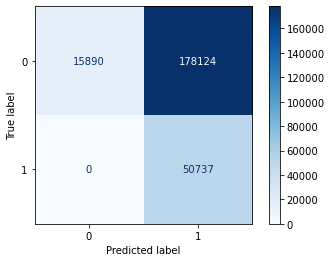

In [24]:
model = XGBClassifier()

y_train = sample_train['new_target']
y_test = sample_test['target']

print(f'y_train:\n {y_train.value_counts()}\ny_test:\n {y_test.value_counts()}\n')

model.fit(sample_train.loc[:, ~sample_train.columns.isin(['target',
                                                          'unlabeled_target',
                                                          'new_target',
                                                          'predict_proba'])].values, 
          sample_train['new_target'].values)
y_predict = model.predict(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target',
                                                                        'predict_proba'])].values)
print('25% labels with RSN в 2 захода:')
evaluate_results(sample_test['target'].values, y_predict)

plot_confusion_matrix(model,
                      sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                    'unlabeled_target',
                                                                    'new_target',
                                                                    'predict_proba'])].values,
                      y_test,
                      cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('0.2% RNS 2 cycles')
metrics['f1_score'].append(f1_score(sample_test['target'].values, y_predict))
metrics['roc'].append(roc_auc_score(sample_test['target'].values, y_predict))
metrics['recall'].append(recall_score(sample_test['target'].values, y_predict, average='binary'))
metrics['precision'].append(precision_score(sample_test['target'].values, y_predict, average='binary'))

**Обучим XGBClassifier() с параметрами по умолчанию на датасете с 0.2% размеченных данных**

y_train:
 0    195967
1        78
Name: new_target, dtype: int64
y_test:
 0    48988
1       24
Name: new_target, dtype: int64

Classification results:
f1: 0.00%
roc: 50.00%
recall: 0.00%
precision: 0.00%


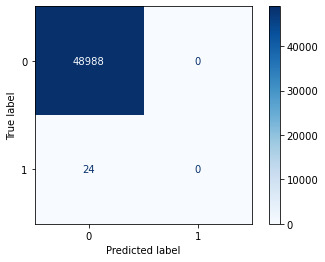

In [25]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target', 'unlabeled_target', 'new_target'])]
y = mod_df['new_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'y_train:\n {y_train.value_counts()}\ny_test:\n {y_test.value_counts()}\n')

model = XGBClassifier()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

evaluate_results(y_test, y_predict)

plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()


metrics['method'].append('0.2% labels with simple xgboost')
metrics['f1_score'].append(f1_score(y_test, y_predict))
metrics['roc'].append(roc_auc_score(y_test, y_predict))
metrics['recall'].append(recall_score(y_test, y_predict, average='binary'))
metrics['precision'].append(precision_score(y_test, y_predict, average='binary'))

**Обучим XGBClassifier() с параметрами по умолчанию на датасете с 0.2% размеченных данных и использованием RandomUnderSampler**

0    102
1    102
Name: new_target, dtype: int64

0.2% labels with RandomUnderSampler:
Classification results:
f1: 0.41%
roc: 88.70%
recall: 97.06%
precision: 0.21%


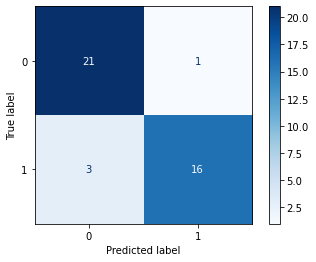

In [26]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target', 'unlabeled_target', 'new_target'])]
y = mod_df['new_target']

RUS = RandomUnderSampler(sampling_strategy='majority')

X_res, y_res = RUS.fit_resample(X, y)

display(y_res.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)
y_predict = model.predict(X)

print('0.2% labels with RandomUnderSampler:')
evaluate_results(y, y_predict)

plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('0.2% labels RandomUnderSampler')
metrics['f1_score'].append(f1_score(y, y_predict))
metrics['roc'].append(roc_auc_score(y, y_predict))
metrics['recall'].append(recall_score(y, y_predict, average='binary'))
metrics['precision'].append(precision_score(y, y_predict, average='binary'))

***

## RNS + SPY

1. **Оставлем только 25% positives размеченными**

In [27]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 22.5% positives размеченными и 2.5% spy
pos_sample_len = int(np.ceil(0.225 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]
spy_sample = pos_ind[pos_sample_len: pos_sample_len + 1271]

mod_df['unlabeled_target'] = -1
mod_df['spy_target'] = 0
mod_df.loc[pos_sample,'unlabeled_target'] = 1
mod_df.loc[spy_sample,'spy_target'] = 1
print('target variable:\n', mod_df['unlabeled_target'].value_counts())

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('\ntarget variable:\n', mod_df['new_target'].value_counts())

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['unlabeled_target']==-1][:len(mod_df[mod_df['unlabeled_target']==1])]
sample_test = mod_df[mod_df['unlabeled_target']==-1][len(mod_df[mod_df['unlabeled_target']==1]):]
pos_sample = mod_df[mod_df['unlabeled_target']==1]
print(f'\nneg_sample: {neg_sample.shape}, pos_sample: {pos_sample.shape}')
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

print('\nsample_train:')
display(sample_train.head(2))
print('\nnew_target variable:\n', sample_train['new_target'].value_counts(), '\n')

model = XGBClassifier()
model.fit(sample_train.loc[:, ~sample_train.columns.isin(['target',
                                                          'unlabeled_target',
                                                          'new_target',
                                                          'spy_target'])].values, 
          sample_train['new_target'].values)

y_predict_proba = model.predict_proba(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                                    'unlabeled_target',
                                                                                    'new_target',
                                                                                    'spy_target'])].values)
sample_test['predict_proba'] = y_predict_proba[:, 0]

# Посмотрим на уверенность модели для SPY target. За порог возьмём уверенность для 3е по возрастанию значение
threshold = 1 - sorted(sample_test['predict_proba'].loc[sample_test['spy_target'] == 1].to_list())[2]

mod_df = pd.concat([mod_df, sample_test['predict_proba'].loc[sample_test['predict_proba'] > threshold]],
                                axis=1)
mod_df.fillna(0, inplace=True)

Используем 11444/50859 как позитивные примеры, а остальное - неразмеченные

target variable:
 -1    233613
 1     11444
Name: unlabeled_target, dtype: int64

target variable:
 0    233613
1     11444
Name: new_target, dtype: int64

neg_sample: (11444, 7), pos_sample: (11444, 7)

sample_train:


attr_1  attr_2  attr_3  target  unlabeled_target  spy_target  \
64853     198     198     158       0                -1           0   
7779      151     178     222       1                 1           0   

       new_target  
64853           0  
7779            1


new_target variable:
 0    11444
1    11444
Name: new_target, dtype: int64 



In [28]:
# получаем индексы strong negative samples
strong_neg_ind = np.where(mod_df['predict_proba'].values > 0.1)[0]
mod_df.drop(columns=['predict_proba'], inplace=True)
# перемешиваем
np.random.shuffle(strong_neg_ind)
strong_neg_sample = strong_neg_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2, 'unlabeled_target'] = 1
mod_df.loc[strong_neg_sample, 'unlabeled_target'] = 0

mod_df['new_target'] = 0
mod_df.loc[pos_sample_2,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['unlabeled_target']==0][:len(mod_df[mod_df['unlabeled_target']==1])]
sample_test = mod_df[mod_df['unlabeled_target']==-1][len(mod_df[mod_df['unlabeled_target']==1]):]
pos_sample = mod_df[mod_df['unlabeled_target']==1]
print(f'strong_neg_sample: {neg_sample.shape}, pos_sample: {pos_sample.shape}')
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

new_target:
 0    233613
1     11444
Name: new_target, dtype: int64 

strong_neg_sample: (11444, 7), pos_sample: (11444, 7)


In [29]:
print('sample_train')
display(sample_train.shape)
display(sample_train.head(2))

sample_train


(22888, 7)

attr_1  attr_2  attr_3  target  unlabeled_target  spy_target  \
223259      52      56      20       0                 0           0   
110995      93      91      37       0                 0           0   

        new_target  
223259           0  
110995           0

**Обучим XGBClassifier() с параметрами по умолчанию на датасете с 25% размеченных данных, собранном с RNS and SPY**

y_train:
 0    11444
1    11444
Name: new_target, dtype: int64
y_test:
 0    173419
1     37306
Name: target, dtype: int64

25% RNS and SPY в 2 захода:
Classification results:
f1: 97.57%
roc: 99.46%
recall: 99.98%
precision: 95.27%


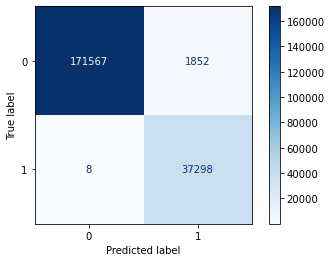

In [30]:
model = XGBClassifier()

y_train = sample_train['new_target']
y_test = sample_test['target']

print(f'y_train:\n {y_train.value_counts()}\ny_test:\n {y_test.value_counts()}\n')

model.fit(sample_train.loc[:, ~sample_train.columns.isin(['target',
                                                          'unlabeled_target',
                                                          'new_target',
                                                          'predict_proba',
                                                          'spy_target'])].values, 
          sample_train['new_target'].values)
y_predict = model.predict(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target',
                                                                        'predict_proba',
                                                                        'spy_target'])].values)
print('25% RNS and SPY в 2 захода:')
evaluate_results(sample_test['target'].values, y_predict)

plot_confusion_matrix(model,
                      sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                    'unlabeled_target',
                                                                    'new_target',
                                                                    'predict_proba',
                                                                    'spy_target'])].values,
                      y_test,
                      cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('25% RNS and SPY 2 cycles')
metrics['f1_score'].append(f1_score(sample_test['target'].values, y_predict))
metrics['roc'].append(roc_auc_score(sample_test['target'].values, y_predict))
metrics['recall'].append(recall_score(sample_test['target'].values, y_predict, average='binary'))
metrics['precision'].append(precision_score(sample_test['target'].values, y_predict, average='binary'))

2. **Оставлем только 0.2% positives размеченными**

In [31]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 0.18% positives размеченными и 0.02% spy
pos_sample_len = int(np.ceil(0.0018 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]
spy_sample = pos_ind[pos_sample_len: pos_sample_len + 10]

mod_df['unlabeled_target'] = -1
mod_df['spy_target'] = 0
mod_df.loc[pos_sample,'unlabeled_target'] = 1
mod_df.loc[spy_sample,'spy_target'] = 1
print('target variable:\n', mod_df['unlabeled_target'].value_counts())

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('\ntarget variable:\n', mod_df['new_target'].value_counts())

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['unlabeled_target']==-1][:len(mod_df[mod_df['unlabeled_target']==1])]
sample_test = mod_df[mod_df['unlabeled_target']==-1][len(mod_df[mod_df['unlabeled_target']==1]):]
pos_sample = mod_df[mod_df['unlabeled_target']==1]
print(f'\nneg_sample: {neg_sample.shape}, pos_sample: {pos_sample.shape}')
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

print('\nsample_train:')
display(sample_train.head(2))
print('\nnew_target variable:\n', sample_train['new_target'].value_counts(), '\n')

model = XGBClassifier()
model.fit(sample_train.loc[:, ~sample_train.columns.isin(['target',
                                                          'unlabeled_target',
                                                          'new_target',
                                                          'spy_target'])].values, 
          sample_train['new_target'].values)

y_predict_proba = model.predict_proba(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                                    'unlabeled_target',
                                                                                    'new_target',
                                                                                    'spy_target'])].values)
sample_test['predict_proba'] = y_predict_proba[:, 0]

# Посмотрим на уверенность модели для SPY target. За порог возьмём уверенность для 3е по возрастанию значение
threshold = 1 - sorted(sample_test['predict_proba'].loc[sample_test['spy_target'] == 1].to_list())[2]

mod_df = pd.concat([mod_df, sample_test['predict_proba'].loc[sample_test['predict_proba'] > threshold]],
                                axis=1)
mod_df.fillna(0, inplace=True)

Используем 92/50859 как позитивные примеры, а остальное - неразмеченные

target variable:
 -1    244965
 1        92
Name: unlabeled_target, dtype: int64

target variable:
 0    244965
1        92
Name: new_target, dtype: int64

neg_sample: (92, 7), pos_sample: (92, 7)

sample_train:


attr_1  attr_2  attr_3  target  unlabeled_target  spy_target  \
67546     170     169     119       0                -1           0   
8321      153     186     231       1                 1           0   

       new_target  
67546           0  
8321            1


new_target variable:
 0    92
1    92
Name: new_target, dtype: int64 



In [32]:
# получаем индексы strong negative samples
strong_neg_ind = np.where(mod_df['predict_proba'].values > 0.1)[0]
mod_df.drop(columns=['predict_proba'], inplace=True)
# перемешиваем
np.random.shuffle(strong_neg_ind)
strong_neg_sample = strong_neg_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2, 'unlabeled_target'] = 1
mod_df.loc[strong_neg_sample, 'unlabeled_target'] = 0

mod_df['new_target'] = 0
mod_df.loc[pos_sample_2,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['unlabeled_target']==0][:len(mod_df[mod_df['unlabeled_target']==1])]
sample_test = mod_df[mod_df['unlabeled_target']==-1][len(mod_df[mod_df['unlabeled_target']==1]):]
pos_sample = mod_df[mod_df['unlabeled_target']==1]
print(f'strong_neg_sample: {neg_sample.shape}, pos_sample: {pos_sample.shape}')
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

new_target:
 0    244965
1        92
Name: new_target, dtype: int64 

strong_neg_sample: (92, 7), pos_sample: (92, 7)


In [33]:
print('sample_train')
display(sample_train.shape)
display(sample_train.head(2))

sample_train


(184, 7)

attr_1  attr_2  attr_3  target  unlabeled_target  spy_target  \
46436     114     143     218       1                 1           0   
40975      92     127     200       1                 1           0   

       new_target  
46436           1  
40975           1

**Обучим XGBClassifier() с параметрами по умолчанию на датасете с 0.2% размеченных данных, собранном с RNS and SPY**

y_train:
 0    92
1    92
Name: new_target, dtype: int64
y_test:
 0    194034
1     50747
Name: target, dtype: int64

0.2% RNS and SPY в 2 захода:
Classification results:
f1: 82.66%
roc: 94.04%
recall: 98.49%
precision: 71.21%


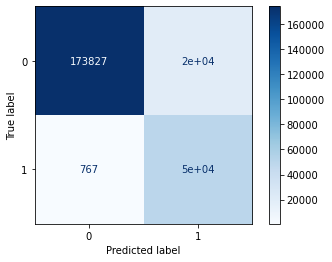

In [34]:
model = XGBClassifier()

y_train = sample_train['new_target']
y_test = sample_test['target']

print(f'y_train:\n {y_train.value_counts()}\ny_test:\n {y_test.value_counts()}\n')

model.fit(sample_train.loc[:, ~sample_train.columns.isin(['target',
                                                          'unlabeled_target',
                                                          'new_target',
                                                          'predict_proba',
                                                          'spy_target'])].values, 
          sample_train['new_target'].values)
y_predict = model.predict(sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                        'unlabeled_target',
                                                                        'new_target',
                                                                        'predict_proba',
                                                                        'spy_target'])].values)
print('0.2% RNS and SPY в 2 захода:')
evaluate_results(sample_test['target'].values, y_predict)

plot_confusion_matrix(model,
                      sample_test.loc[:, ~sample_test.columns.isin(['target',
                                                                    'unlabeled_target',
                                                                    'new_target',
                                                                    'predict_proba',
                                                                    'spy_target'])].values,
                      y_test,
                      cmap=plt.cm.Blues)
plt.show()

metrics['method'].append('0.2% RNS and SPY 2 cycles')
metrics['f1_score'].append(f1_score(sample_test['target'].values, y_predict))
metrics['roc'].append(roc_auc_score(sample_test['target'].values, y_predict))
metrics['recall'].append(recall_score(sample_test['target'].values, y_predict, average='binary'))
metrics['precision'].append(precision_score(sample_test['target'].values, y_predict, average='binary'))

***

## PULearn

В статье (https://cseweb.ucsd.edu/~elkan/posonly.pdf) авторы предлагают использовать "нестандартный" набор данных для обучения обычного классификатора.

Предположим, что у нас есть датасет, где target - бинарная переменная, которой присваивается метка $y = 0$ или $y = 1$.

Пусть $x$ - значение target для каждой строки в датасете. Пусть $s = 1$ если $x$ - размеченный $(x = 1)$ и $s = 0$, если $x$ - неразмеченный ($x = 1$ или $x = 0$).

Так как у нас размечены только позитивные примеры, то $y = 1$ тогда, когда $s = 1$, но если $s = 0$ - мы не знаем наверняка: $y = 1$ или $y = 0$.

В статье авторы рассматривают $x, y, s$ как случайные переменные. Для этих переменных существует какое-то фиксированное неизвестное распределение $p(x, y, s)$.

Этот "нестандартный" набор данных представляет собой выборку, взятую из указанного выше распределения, которая состоит из неразмеченных примеров $(x, s = 0)$ и размеченных примеров $(x, s = 1)$. Тот факт, что помечены только положительные примеры, формально можно сформулировать как уравнение:


\begin{equation}
p(s=1|x, y=0) = 0
\end{equation}

Или простыми словами: вероятность того, что $x$ в размеченном наборе равна нулю, если $y=0$.

Обучающие данные выбираются случайным образом из $p(x, y, s)$, но для каждого из выбранных $(x, y, s)$ записывается только $(x, s)$

Основное предположение в данной работе заключается в том, что размеченные positives примеры выбираются совершенно случайным образом из всех positives. Это значит, что если $y = 1$, то вероятность того, что positive пример размечен, будет постоянной, независимо от $x$. Формально:

\begin{equation}
p(s=1|x,y=1)=p(s=1|y=1)
\end{equation}

где 

\begin{equation}
p (s = 1 | y = 1) = с 
\end{equation}

$c$ - постоянная вероятность того, что положительный пример помечен.

Итак, обучающий набор данных представляет собой случайную выборку из распределения $p(x, y, s)$, которая удовлетворяет уравнениям (1) и (2). Этот обучайщий набор состоит из двух подмножеств: "размеченных" $(s=1)$ и "неразмеченных" $(s=0)$.

Предположим, мы подаём эти два подмножества в качестве входных данных для обычного алгоритма обучения (в нашем случае - классификации). В таком случае алгоритм вернёт нам такую функцию $g(x)$, что 

$$g(x) \approx p(s=1|x)$$

Авторы называют $g(x)$ "нестандартным" классификатором и их главная цель это следующая лемма, которая показывает как получить обычный классификатор $f(x)$ из $g(x)$.

***Лемма 1***:

Предположим, что размеченные positives выбраны абсолютно случайным образом. Тогда:
$$p(y = 1 | x) = p (s = 1 | x) / c$$ где $$c = p (s = 1 | y = 1)$$

Или простыми словами: вероятность $y=1$ с учётом $x$ равна вероятности $s=1$ с учётом $x$, делённой на $c$. Где $c$ - постоянная вероятность того, что выбран размеченный экземпляр.

**Доказательство:**

\begin{align*}
 g(x) \approx p(s=1|x) &= p(y=1 \wedge s=1|x) \\
      &= p(y=1|x)p(s=1|x, y=1) \\
      &= p(y=1|x)p(s=1|y=1)
\end{align*}

Если мы разделим полученное выражение на $p(s=1|y=1)$, то получим искомую функцию $f(x)$

\begin{align*}
f(x) = \frac {g(x)}{p(s=1|y=1)} = \frac {g(x)}{c}
\end{align*}

**Мы покажем, что $e_1 = p (s = 1 | y = 1) = c$, если это так, то $g (x) = p (s = 1 | x)$ для всех $x$.**

**Для этого всё, что нам нужно доказать: $g(x) = c$ для $x∈P$. Мы можем сделать это следующим образом:**

Стоит отметить несколько следствий из этой леммы:

Во-первых, $f$ - возрастающая функция от $g$. Это значит, что если классификатор $f$ используется только для ранжирования примеров $x$ в соответствии с вероятностью того, что они принадлежат классу $y=1$, то можно напрямую использовать классификатор $g$ вместо $f$.

Во-вторых, $f \leq 1$ только если $g \leq p(s=1|y=1)$. Это значит, что $g > p(s=1|y=1)$ не может быть. Это логично, потому что $positive$ (размеченный) и $negative$ (неразмеченный) обучающие наборы данных для $g$ являются выборками из пересекающихся областей в пространстве $x$. Следовательно, ни один экземпляр $x$ не может принадлежать к $positive$ классу для $g$ с высокой степенью вероятности.

Значение константы $c=p(s=1|y=1)$ можно оценить с помощью обученного классификатора $g$ и набора примеров для проверки.

Пусть $V$ будет таким тестовым набором, который извлекается из общего распределения $p(x,y,s)$ таким же способом, что и "нестандартный" обучающий набор данных. Пусть $P$ - подмножество размеченных (и, следовательно, положительных) примеров в $V$. "Оценка" $p(s=1|y=1)$ - это среднее значение $g(x)$ для $x$ в $P$. 

Формально "оценка":

\begin{align*}
e_1 = \frac {1}{n} \sum_{x\in P} g(x)
\end{align*}

где $n$ - мощность множества $P$

Мы должны доказать что $e_1 = p(s=1|y=1)=c$. Если это так, то $g(x) = p(s=1|x)$ для всех $x$.
Для этого всё что нам нужно это доказать что $g(x) = c$ для $x \in P$.

\begin{align*}
 g(x) &= p(s=1|x) \\ 
      &= p(s=1|x, y=1)p(y=1|x) + p(s=1|x, y=0)p(y=0|x) \\
      &= p(s=1|x,y=1) \times 1+0 \times 0 \quad т. к. \quad x \in P \\
      &= p(s=1|y=1)
\end{align*}

Есть ещё два "оценщика":

\begin{align*}
e_2 = \frac {\sum_{x\in P} g(x)}{\sum_{x\in V} g(x)}
\end{align*}

\begin{align*}
e_3 = \substack{max \\ x\in V} g(x)
\end{align*}

В качестве вывода авторы утверждают, что на практике лучше всего использовать первый "оценщик" $e_1$.

На практике, когда $g(x) != p(s=1|x)$, $e_1$ по-прежнему является лучшим вариантом.

По сравнению с $e_3$ он имеет гораздо меньшую дисперсию, потому что он основан на усреднении по $n$ примерам, а не только на единственном примере.

У $e_1$ так же будет немного меньшая дисперсия чем у $e_2$, потому что $e_2$ подвергается дополнительной дисперсии через свой знаменатель.

В принципе, любого единичного примера из $P$ достаточно для определения $c$, но на практике предпочтительно усреднение всех членов $P$.

***

![ab_split](example4.png "example3")

***

Имплементация в коде (https://towardsdatascience.com/semi-supervised-classification-of-unlabeled-data-pu-learning-81f96e96f7cb):

In [35]:
def fit_PU_estimator(X, y, hold_out_ratio, estimator):
    
    # находим индексы positive (рзамеченных) элементов
    assert (type(y) == np.ndarray), "Must pass np.ndarray rather than list as y"
    positives = np.where(y == 1.)[0] 
    # hold_out_size это кол-во positive (рзамеченных) элементов
    # которые мы будем использовать позже для нахождения P(s=1|y=1)
    hold_out_size = int(np.ceil(len(positives) * hold_out_ratio))
    np.random.shuffle(positives)
    # hold_out это индексы positive (рзамеченных) элементов
    # которые мы будем использовать позже для нахождения P(s=1|y=1)
    hold_out = positives[:hold_out_size] 
    # X_hold_out это positive (рзамеченные) элементы, которые мы отложим
    X_hold_out = X[hold_out] 
    # удалим отложенные элементы из X и y
    X = np.delete(X, hold_out, 0) 
    y = np.delete(y, hold_out)
    # Будем обучать модель на неразмеченных элементах + часть размеченных positive элементов
    # Чтобы получить вероятность P(s=1|x) того, что элемент размечен
    estimator.fit(X, y)
    # Используем обученную модель для предсказания вероятности P(s=1|y=1) 
    # что x размечен на отложенной выборке
    hold_out_predictions = estimator.predict_proba(X_hold_out)
    # возьмём вероятность принадлеждности к классу 1
    hold_out_predictions = hold_out_predictions[:, 1]
    # сохраним усреднённую вероятность
    c = np.mean(hold_out_predictions)
    return estimator, c

def predict_PU_prob(X, estimator, prob_s1_y1):
    predicted_s = estimator.predict_proba(X)
    predicted_s = predicted_s[:,1]
    return predicted_s / prob_s1_y1

In [36]:
def custom_conf_matrix_plot(y_positive, y_predict):
    cm = confusion_matrix(y_positive, y_predict)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    class_names = ['0', '1']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    s = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='w' if (j==0 | i ==0) else 'black')
    plt.show()

1. **Оставляем только 25% positives размеченными**

In [37]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 25% positives размеченными
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2,'unlabeled_target'] = 1
print('unlabeled_target:\n', mod_df['unlabeled_target'].value_counts(), '\n')

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)

Используем 12715/50859 как позитивные примеры, а остальное - неразмеченные

unlabeled_target:
 -1    232342
 1     12715
Name: unlabeled_target, dtype: int64 

new_target:
 0    232342
1     12715
Name: new_target, dtype: int64 



In [38]:
y_labeled = mod_df['unlabeled_target'].values
y_positive = mod_df['target'].values

In [39]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target',
                                        'unlabeled_target',
                                        'new_target'])]
X = np.array(X)

In [40]:
estimator = XGBClassifier()
predicted = np.zeros(len(X))
learning_iterations = 12
for index in range(learning_iterations):
    pu_estimator, prob_s1_y1 = fit_PU_estimator(X, y_labeled, 0.2, estimator)
    predicted += predict_PU_prob(X, pu_estimator, prob_s1_y1)
    if(index%4 == 0): 
        print(f'Learning Iteration::{index}/{learning_iterations} => P(s=1|y=1)={round(prob_s1_y1, 2)}')

Learning Iteration::0/12 => P(s=1|y=1)=0.20999999344348907
Learning Iteration::4/12 => P(s=1|y=1)=0.20999999344348907
Learning Iteration::8/12 => P(s=1|y=1)=0.20999999344348907


Classification results:
f1: 99.39%
roc: 99.45%
recall: 98.93%
precision: 99.85%


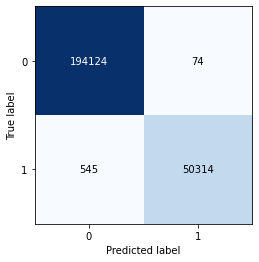

In [41]:
y_predict = [1 if x > 0.5 else 0 for x in (predicted / learning_iterations)]

evaluate_results(y_positive, y_predict)

custom_conf_matrix_plot(y_positive, y_predict)

metrics['method'].append('25% Elkanoto')
metrics['f1_score'].append(f1_score(y_positive, y_predict))
metrics['roc'].append(roc_auc_score(y_positive, y_predict))
metrics['recall'].append(recall_score(y_positive, y_predict, average='binary'))
metrics['precision'].append(precision_score(y_positive, y_predict, average='binary'))

2. **Оставляем только 0.2% positives размеченными**

Используем 1018/50859 как позитивные примеры, а остальное - неразмеченные

unlabeled_target:
 -1    244039
 1      1018
Name: unlabeled_target, dtype: int64 

new_target:
 0    244039
1      1018
Name: new_target, dtype: int64 

Learning Iteration::0/12 => P(s=1|y=1)=0.019999999552965164
Learning Iteration::4/12 => P(s=1|y=1)=0.019999999552965164
Learning Iteration::8/12 => P(s=1|y=1)=0.019999999552965164
Classification results:
f1: 92.61%
roc: 93.24%
recall: 86.58%
precision: 99.54%


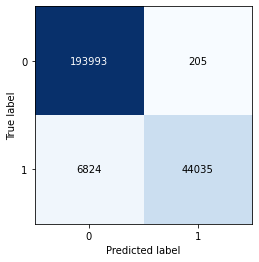

In [42]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 25% positives размеченными
pos_sample_len = int(np.ceil(0.02 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2,'unlabeled_target'] = 1
print('unlabeled_target:\n', mod_df['unlabeled_target'].value_counts(), '\n')

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)

y_labeled = mod_df['unlabeled_target'].values
y_positive = mod_df['target'].values

X = mod_df.loc[:, ~mod_df.columns.isin(['target',
                                        'unlabeled_target',
                                        'new_target'])]
X = np.array(X)

estimator = XGBClassifier()
predicted = np.zeros(len(X))
learning_iterations = 12
for index in range(learning_iterations):
    pu_estimator, prob_s1_y1 = fit_PU_estimator(X, y_labeled, 0.2, estimator)
    predicted += predict_PU_prob(X, pu_estimator, prob_s1_y1)
    if(index%4 == 0): 
        print(f'Learning Iteration::{index}/{learning_iterations} => P(s=1|y=1)={round(prob_s1_y1,2)}')
        
y_predict = [1 if x > 0.5 else 0 for x in (predicted / learning_iterations)]

evaluate_results(y_positive, y_predict)

custom_conf_matrix_plot(y_positive, y_predict)

metrics['method'].append('0.2% Elkanoto')
metrics['f1_score'].append(f1_score(y_positive, y_predict))
metrics['roc'].append(roc_auc_score(y_positive, y_predict))
metrics['recall'].append(recall_score(y_positive, y_predict, average='binary'))
metrics['precision'].append(precision_score(y_positive, y_predict, average='binary'))

***

## PULearn Lib

https://github.com/pulearn/pulearn

In [43]:
from pulearn import ElkanotoPuClassifier, WeightedElkanotoPuClassifier

1. **Оставляем только 25% positives размеченными**

In [44]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 25% positives размеченными
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2,'unlabeled_target'] = 1
print('unlabeled_target:\n', mod_df['unlabeled_target'].value_counts(), '\n')

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)

Используем 12715/50859 как позитивные примеры, а остальное - неразмеченные

unlabeled_target:
 -1    232342
 1     12715
Name: unlabeled_target, dtype: int64 

new_target:
 0    232342
1     12715
Name: new_target, dtype: int64 



In [45]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target',
                                        'unlabeled_target',
                                        'new_target'])]
X = np.array(X)
y = mod_df['new_target']
y = np.array(y)

In [46]:
y[np.where(y == 0)] = -1.
y[np.where(y == 1)] = +1.
print(f'Loaded {len(y)} examples')
print(f'{len(np.where(y == -1.)[0])} are zeroes')
print(f'{len(np.where(y == +1.)[0])} are positives')
print('\nSplitting dataset into test/train sets...')
split = int(2 * len(y) / 3)
# Select elements from 0 to split-1 (including both ends)
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]
print(f'Training set contains {len(y_train)} examples')
print(f'{len(np.where(y_train == -1.)[0])} are zeroes')
print(f'{len(np.where(y_train == +1.)[0])} are positives')

Loaded 245057 examples
232342 are zeroes
12715 are positives

Splitting dataset into test/train sets...
Training set contains 163371 examples
154782 are zeroes
8589 are positives


Estimator: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
p(s=1|y=1,x) ~= 1.0
Fitted: False
25% labels with PULearn:
f1 score: 0.3885377972888224
precision: 0.24254652773595134
recall: 0.9760058167716917


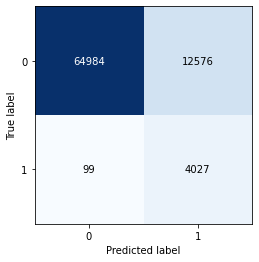

In [47]:
estimator = XGBClassifier()

pu_estimator = ElkanotoPuClassifier(estimator)
print(pu_estimator)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict(X_test)

pu_precision, pu_recall, pu_f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

print('25% labels with PULearn:')
print(f'f1 score: {pu_f1_score[1]}')
print(f'precision: {pu_precision[1]}')
print(f'recall: {pu_recall[1]}')

custom_conf_matrix_plot(y_test, y_pred)
plt.show()

metrics['method'].append('25% labels PULearn Lib')
metrics['f1_score'].append(pu_f1_score[1])
metrics['roc'].append(roc_auc_score(y_test, y_pred))
metrics['recall'].append(pu_recall[1])
metrics['precision'].append(pu_precision[1])

***

2. **Оставлем только 0.2% positives размеченными**

In [48]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 0.2% positives размеченными
pos_sample_len = int(np.ceil(0.002 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample,'unlabeled_target'] = 1
print('target variable:\n', mod_df['unlabeled_target'].value_counts())

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('\ntarget variable:\n', mod_df['new_target'].value_counts())

mod_df = mod_df.sample(frac=1)

Используем 102/50859 как позитивные примеры, а остальное - неразмеченные

target variable:
 -1    244955
 1       102
Name: unlabeled_target, dtype: int64

target variable:
 0    244955
1       102
Name: new_target, dtype: int64


In [49]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target',
                                        'unlabeled_target',
                                        'new_target'])]
X = np.array(X)
y = mod_df['new_target']
y = np.array(y)

In [50]:
y[np.where(y == 0)] = -1.
y[np.where(y == 1)] = +1.
print(f'Loaded {len(y)} examples')
print(f'{len(np.where(y == -1.)[0])} are zeroes')
print(f'{len(np.where(y == +1.)[0])} are positives')
print('\nSplitting dataset into test/train sets...')
split = int(2 * len(y) / 3)
# Select elements from 0 to split-1 (including both ends)
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]
print(f'Training set contains {len(y_train)} examples')
print(f'{len(np.where(y_train == -1.)[0])} are zeroes')
print(f'{len(np.where(y_train == +1.)[0])} are positives')

Loaded 245057 examples
244955 are zeroes
102 are positives

Splitting dataset into test/train sets...
Training set contains 163371 examples
163305 are zeroes
66 are positives


Estimator: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
p(s=1|y=1,x) ~= 1.0
Fitted: False
0.2% labels with PULearn:
f1 score: 0.004704775346977181
precision: 0.0023623907394283014
recall: 0.5555555555555556


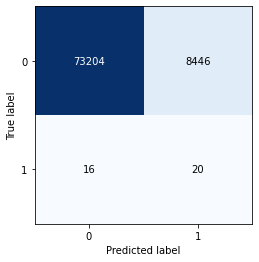

In [51]:
estimator = XGBClassifier()

pu_estimator = ElkanotoPuClassifier(estimator)
print(pu_estimator)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict(X_test)

pu_precision, pu_recall, pu_f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

print('0.2% labels with PULearn:')
print(f'f1 score: {pu_f1_score[1]}')
print(f'precision: {pu_precision[1]}')
print(f'recall: {pu_recall[1]}')

custom_conf_matrix_plot(y_test, y_pred)
plt.show()

metrics['method'].append('0.2% labels PULearn Lib')
metrics['f1_score'].append(pu_f1_score[1])
metrics['roc'].append(roc_auc_score(y_test, y_pred))
metrics['recall'].append(pu_recall[1])
metrics['precision'].append(pu_precision[1])

***

**Weighted PuClassifier**

In [52]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 25% positives размеченными
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample_2,'unlabeled_target'] = 1
print('unlabeled_target:\n', mod_df['unlabeled_target'].value_counts(), '\n')

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('new_target:\n', mod_df['new_target'].value_counts(), '\n')

mod_df = mod_df.sample(frac=1)

Используем 12715/50859 как позитивные примеры, а остальное - неразмеченные

unlabeled_target:
 -1    232342
 1     12715
Name: unlabeled_target, dtype: int64 

new_target:
 0    232342
1     12715
Name: new_target, dtype: int64 



In [53]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target',
                                        'unlabeled_target',
                                        'new_target'])]
X = np.array(X)
y = mod_df['new_target']
y = np.array(y)

In [54]:
y[np.where(y == 0)] = -1.
y[np.where(y == 1)] = +1.
print(f'Loaded {len(y)} examples')
print(f'{len(np.where(y == -1.)[0])} are zeroes')
print(f'{len(np.where(y == +1.)[0])} are positives')
print('\nSplitting dataset into test/train sets...')
split = int(2 * len(y) / 3)
# Select elements from 0 to split-1 (including both ends)
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]
print(f'Training set contains {len(y_train)} examples')
print(f'{len(np.where(y_train == -1.)[0])} are zeroes')
print(f'{len(np.where(y_train == +1.)[0])} are positives')

Loaded 245057 examples
232342 are zeroes
12715 are positives

Splitting dataset into test/train sets...
Training set contains 163371 examples
154919 are zeroes
8452 are positives


Estimator: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
p(s=1|y=1,x) ~= 1.0
Fitted: False
25% labels with PULearn WeightedElkanoto:
f1 score: 0.0032717924748773075
precision: 0.4375
recall: 0.0016420361247947454


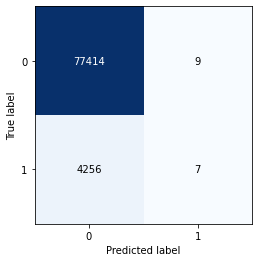

In [55]:
estimator = XGBClassifier()

pos = len(np.where(y_train == +1.)[0])
unlabelled = len(np.where(y_train == -1.)[0])
pu_estimator = WeightedElkanotoPuClassifier(estimator, pos, unlabelled)
print(pu_estimator)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict(X_test)

pu_precision, pu_recall, pu_f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

print('25% labels with PULearn WeightedElkanoto:')
print(f'f1 score: {pu_f1_score[1]}')
print(f'precision: {pu_precision[1]}')
print(f'recall: {pu_recall[1]}')

custom_conf_matrix_plot(y_test, y_pred)
plt.show()

metrics['method'].append('25% labels Weighted PULearn Lib')
metrics['f1_score'].append(pu_f1_score[1])
metrics['roc'].append(roc_auc_score(y_test, y_pred))
metrics['recall'].append(pu_recall[1])
metrics['precision'].append(pu_precision[1])

***

In [56]:
mod_df = df.copy()
# получаем индексы positive samples
pos_ind = np.where(mod_df['target'].values == 1)[0]
# перемешиваем
np.random.shuffle(pos_ind)
# оставляем 0.2% positives размеченными
pos_sample_len = int(np.ceil(0.002 * len(pos_ind)))
print(f'Используем {pos_sample_len}/{len(pos_ind)} как позитивные примеры, а остальное - неразмеченные\n')
pos_sample = pos_ind[:pos_sample_len]
pos_sample_2 = pos_ind[:pos_sample_len]

mod_df['unlabeled_target'] = -1
mod_df.loc[pos_sample,'unlabeled_target'] = 1
print('target variable:\n', mod_df['unlabeled_target'].value_counts())

mod_df['new_target'] = 0
mod_df.loc[pos_sample,'new_target'] = 1
print('\ntarget variable:\n', mod_df['new_target'].value_counts())

mod_df = mod_df.sample(frac=1)

Используем 102/50859 как позитивные примеры, а остальное - неразмеченные

target variable:
 -1    244955
 1       102
Name: unlabeled_target, dtype: int64

target variable:
 0    244955
1       102
Name: new_target, dtype: int64


In [57]:
X = mod_df.loc[:, ~mod_df.columns.isin(['target',
                                        'unlabeled_target',
                                        'new_target'])]
X = np.array(X)
y = mod_df['new_target']
y = np.array(y)

In [58]:
y[np.where(y == 0)] = -1.
y[np.where(y == 1)] = +1.
print(f'Loaded {len(y)} examples')
print(f'{len(np.where(y == -1.)[0])} are zeroes')
print(f'{len(np.where(y == +1.)[0])} are positives')
print('\nSplitting dataset into test/train sets...')
split = int(2 * len(y) / 3)
# Select elements from 0 to split-1 (including both ends)
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]
print(f'Training set contains {len(y_train)} examples')
print(f'{len(np.where(y_train == -1.)[0])} are zeroes')
print(f'{len(np.where(y_train == +1.)[0])} are positives')

Loaded 245057 examples
244955 are zeroes
102 are positives

Splitting dataset into test/train sets...
Training set contains 163371 examples
163302 are zeroes
69 are positives


Estimator: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
p(s=1|y=1,x) ~= 1.0
Fitted: False
0.2% labels with PULearn WeightedElkanoto:
f1 score: 0.0
precision: 0.0
recall: 0.0


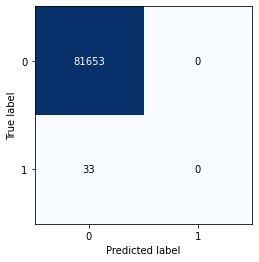

In [59]:
estimator = XGBClassifier()

pos = len(np.where(y_train == +1.)[0])
unlabelled = len(np.where(y_train == -1.)[0])
pu_estimator = WeightedElkanotoPuClassifier(estimator, pos, unlabelled)
print(pu_estimator)
pu_estimator.fit(X_train, y_train)

y_pred = pu_estimator.predict(X_test)

pu_precision, pu_recall, pu_f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

print('0.2% labels with PULearn WeightedElkanoto:')
print(f'f1 score: {pu_f1_score[1]}')
print(f'precision: {pu_precision[1]}')
print(f'recall: {pu_recall[1]}')

custom_conf_matrix_plot(y_test, y_pred)
plt.show()

metrics['method'].append('0.2% labels Weighted PULearn Lib')
metrics['f1_score'].append(pu_f1_score[1])
metrics['roc'].append(roc_auc_score(y_test, y_pred))
metrics['recall'].append(pu_recall[1])
metrics['precision'].append(pu_precision[1])

***

## Metrics

In [60]:
metrics_df = pd.DataFrame(metrics)
metrics_df.sort_values(by='recall', ascending=False)

method  f1_score       roc    recall  precision
2                   25% RNS 2 cycles  0.461098  0.754535  1.000000   0.299628
6                  0.2% RNS 2 cycles  0.362928  0.540951  1.000000   0.221694
9           25% RNS and SPY 2 cycles  0.975672  0.994553  0.999786   0.952695
0                           original  0.998706  0.999518  0.999601   0.997812
4      25% labels RandomUnderSampler  0.399220  0.916939  0.998191   0.249504
1                    25% RNS 1 cycle  0.994787  0.997793  0.997062   0.992523
11                      25% Elkanoto  0.993886  0.994452  0.989284   0.998531
10         0.2% RNS and SPY 2 cycles  0.826567  0.940372  0.984886   0.712098
13            25% labels PULearn Lib  0.388538  0.906930  0.976006   0.242547
8     0.2% labels RandomUnderSampler  0.004096  0.887027  0.970588   0.002052
5                   0.2% RNS 1 cycle  0.878893  0.921677  0.873063   0.884801
12                     0.2% Elkanoto  0.926088  0.932385  0.865825   0.995366
14           0.2% labels PULearn Lib  0.004705  0.726057  0.555556   0.002362
15   25% labels Weighted PULearn Lib  0.003272  0.500763  0.001642   0.437500
3          25% labels simple xgboost  0.001530  0.500234  0.000770   0.125000
7    0.2% labels with simple xgboost  0.000000  0.500000  0.000000   0.000000
16  0.2% labels Weighted PULearn Lib  0.000000  0.500000  0.000000   0.000000